In [1]:
from tsfresh import extract_features, extract_relevant_features
import pandas as pd
import numpy as np
import pickle
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

C:\Users\abcmo\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [1]:
frames = []
counter = 0
for file in tqdm(os.listdir('E:/lightcurves/')):
    filepath = 'E:/lightcurves/' + file
    with open(filepath,'rb') as rfile:
        lc = pickle.load(rfile)
    frames.append(pd.DataFrame({'id':counter*np.ones(len(lc.flux)),'time':lc.time,'flux':lc.flux}))
    counter = counter + 1
timeseries = pd.concat(frames)
extracted_features = extract_features(timeseries, column_id="id", column_sort="time")

C:\Users\811261\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
  0%|                                                                                        | 0/15767 [00:00<?, ?it/s]C:\Users\811261\AppData\Local\Continuum\anaconda3\lib\site-packages\astropy\config\configuration.py:557: ConfigurationMissingWarning: Configuration defaults will be used due to FileNotFoundError:2 on None
  warn(ConfigurationMissingWarning(msg))
100%|███████████████████████████████████████████████████████████████████████████| 15767/15767 [01:52<00:00, 140.18it/s]


In [2]:
extracted_features = pd.read_csv('E:/catalogues/features.csv')

x = np.zeros((len(extracted_features),764))

for n in range(1,len(extracted_features)-1):
    x[n] = extracted_features[n:n+1].to_numpy()[0]

y = np.load("E:/y_cl.npy")
newy = np.zeros(len(y))
for i in range(len(y)):
    newy[i] = np.where(y[i]==1)[0][0]
    
print(x,x.shape)
print(newy,newy.shape)
x_train, x_test, y_train, y_test = train_test_split(x, newy, test_size=0.2, random_state=42)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  3.84350331e+01  2.30129288e+02 ...  3.45945368e-02
   0.00000000e+00 -2.76525100e+02]
 [ 2.00000000e+00  3.52800676e+02  2.34317402e+02 ...  3.15165169e-01
   0.00000000e+00 -1.14901357e+01]
 ...
 [ 1.57640000e+04  3.71757046e+01  1.81648343e+02 ...  4.82739139e-02
   0.00000000e+00  8.80832446e+01]
 [ 1.57650000e+04  4.24466170e+02  2.63749566e+02 ...  4.71791675e-01
   0.00000000e+00  2.30524555e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]] (15767, 764)
[4. 3. 2. ... 4. 0. 1.] (15767,)


In [5]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(x_train, y_train)

y_pred = classifier.predict(x_test)



In [7]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[  0,   0,   0, 340,   0,   0],
       [  0,   0,   0, 334,   0,   0],
       [  0,   0,   0, 508,   0,   0],
       [  0,   0,   0, 730,   0,   0],
       [  0,   0,   0, 698,   0,   0],
       [  0,   0,   0, 544,   0,   0]], dtype=int64)

In [ ]:
from scipy.stats import gaussian_kde
for n in tqdm(range(0,len(extracted_features.columns))):
    try:
        fig = plt.figure(figsize=(10,10))

        plt.title(extracted_features.columns[n][6:])
        plt.xlabel(extracted_features.columns[n])
        plt.ylabel("SMBH Mass")

        stdev = 0.1*np.std(x_train[:,n])
        plt.xlim(np.percentile(x_train[:,n],5)-stdev,np.percentile(x_train[:,n]+stdev,95))

        xy = np.vstack([x_train[:,n],y_train])
        z = gaussian_kde(xy)(xy)
        plt.scatter(x_train[:,n],y_train,c=z,s=1,cmap='jet')
        plt.savefig('E:/corrs/'+str(n)+'.jpg')
        plt.close()
    except:
        pass

In [ ]:
from scipy.stats import gaussian_kde
for n in tqdm(range(0,len(extracted_features.columns))):
    try:
        fig = plt.figure(figsize=(10,10))

        plt.title(extracted_features.columns[n][6:])
        plt.xlabel(extracted_features.columns[n])
        plt.ylabel("SMBH Mass")

        stdev = 0.1*np.std(x_train[:,n])
        #plt.xlim(np.percentile(x_train[:,n],5)-stdev,np.percentile(x_train[:,n]+stdev,95))

        xy = np.vstack([x_train[:,n],y_train])
        z = gaussian_kde(xy)(xy)
        plt.scatter(x_train[:,n],y_train,c=z,s=1,cmap='jet')
        plt.savefig('E:/corrs/'+str(n)+'.jpg')
        plt.close()
    except:
        pass

In [20]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2



bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(np.abs(extracted_features.to_numpy()),y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(extracted_features.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                                              Specs         Score
755  flux__time_reversal_asymmetry_statistic__lag_1  5.939432e+15
756  flux__time_reversal_asymmetry_statistic__lag_2  3.873559e+15
757  flux__time_reversal_asymmetry_statistic__lag_3  2.617784e+15
84                                  flux__c3__lag_1  1.975002e+15
85                                  flux__c3__lag_2  4.370253e+14
86                                  flux__c3__lag_3  1.332512e+14
1                                  flux__abs_energy  1.198094e+13
728               flux__spkt_welch_density__coeff_2  1.352696e+11
729               flux__spkt_welch_density__coeff_5  1.308834e+11
730               flux__spkt_welch_density__coeff_8  1.233989e+11


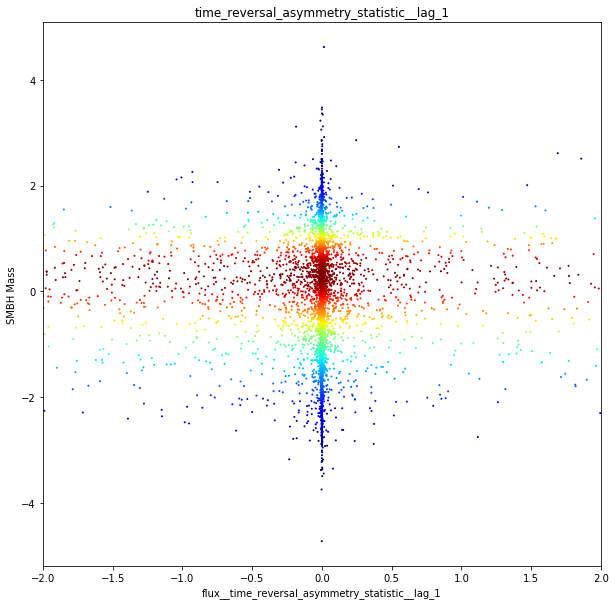

In [57]:
n = 755
fig = plt.figure(figsize=(10,10))

plt.title(extracted_features.columns[n][6:])
plt.xlabel(extracted_features.columns[n])
plt.ylabel("SMBH Mass")

stdev = 0*np.std(x_train[:,n])
plt.xlim(-2,2)

xy = np.vstack([x_train[:,n],y_train])
z = gaussian_kde(xy)(xy)
plt.scatter(x_train[:,n],y_train,c=z,s=1,cmap='jet')

In [72]:
n = 755
fig = plt.figure(figsize=(10,10))

plt.title(extracted_features.columns[n][6:])
plt.xlabel(extracted_features.columns[n])
plt.ylabel("SMBH Mass")

stdev = 0*np.std(x_train[:,n])
plt.xlim(-2,2)

xy = np.vstack([x_train[:,n],y_train])
z = gaussian_kde(xy)(xy)
plt.scatter(x_train[:,n],y_train,c=z,s=1,cmap='jet')

2

 56%|████████████████████████████████████████████▋                                   | 427/764 [17:22<13:53,  2.47s/it]

LinAlgError: singular matrix

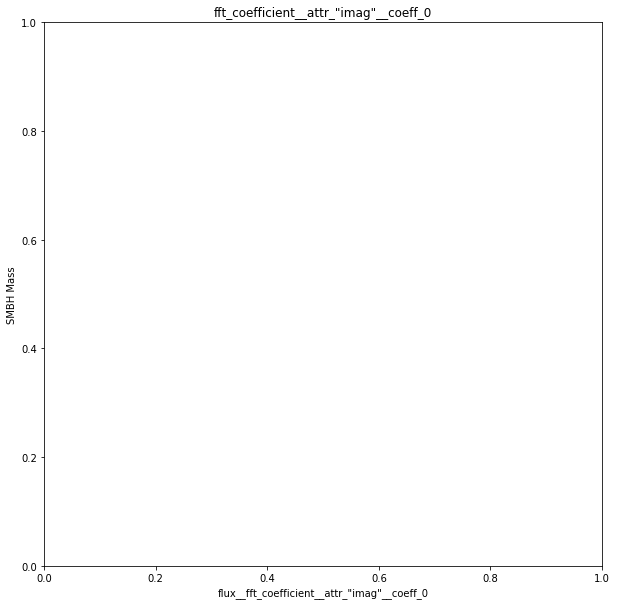

In [5]:
from scipy.stats import gaussian_kde
for n in tqdm(range(0,len(extracted_features.columns))):
    #try:
    fig = plt.figure(figsize=(10,10))

    plt.title(extracted_features.columns[n][6:])
    plt.xlabel(extracted_features.columns[n])
    plt.ylabel("SMBH Mass")

    stdev = 0.1*np.std(x_train[:,n])
    #plt.xlim(np.percentile(x_train[:,n],5)-stdev,np.percentile(x_train[:,n]+stdev,95))

    xy = np.vstack([x_train[:,n],y_train])
    z = gaussian_kde(xy)(xy)
    plt.scatter(x_train[:,n],y_train,c=z,s=1,cmap='jet')
    plt.savefig('E:/corrs_cl/'+str(n)+'.png')
    plt.close()
    #except:
    #    pass

In [11]:
y_train

array([4., 4., 3., ..., 0., 1., 2.])